## Tutorial for histogram matching

In [22]:
import numpy as np
import ot
from scipy.spatial.distance import squareform
from scipy.special import comb
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# %config InlineBackend.figure_formats = {'png', 'retina'} # for notebook?
plt.rcParams["font.size"] = 14

In [23]:
# functions
def sort_for_scaling(X):
    x = squareform(X)
    x_sorted = np.sort(x)
    x_inverse_idx = np.argsort(x).argsort()
    return x, x_sorted, x_inverse_idx

def histogram_matching(X, Y):
    # X, Y: dissimilarity matrices
    x, x_sorted, x_inverse_idx = sort_for_scaling(X)
    y, y_sorted, y_inverse_idx = sort_for_scaling(Y)

    y_t = x_sorted[y_inverse_idx]
    Y_t = squareform(y_t)  # transformed matrix
    return Y_t

def sc_plot(x, y, labels):
    plt.figure()
    plt.plot(x, y, '.')
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.show()


def im_plot(X, Y, title_list):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax, dm, t in zip(axes.reshape(-1), [X, Y], title_list):
        a = ax.imshow(dm)
        ax.set_title(t)
        cbar = fig.colorbar(a, ax=ax, shrink=0.7)
    plt.show()


def gw_alignment(X, Y, epsilon):
    """
    2023/3/3 初期値の決め方を修正(阿部)
    """
    n = X.shape[0]
    p = ot.unif(n)
    q = ot.unif(n)
    gw, log = ot.gromov.entropic_gromov_wasserstein(
        X, Y, p, q, 'square_loss', epsilon=epsilon, log=True, verbose=True)

    plt.figure(figsize=(5, 5))
    sns.heatmap(gw, square=True)
    plt.show()
    return gw, log

In [24]:
# generate disimilarity matrix data
n = 1000  # number of elements
sigma = 1

np.random.seed(seed=42)
x_sim = np.random.uniform(0, 1, size=comb(n, 2, exact=True))
np.random.seed(seed=0)
y_sim = 2 * x_sim + np.random.uniform(0, sigma, size=comb(n, 2, exact=True))

X = squareform(x_sim)  # disimilarity matrix 1
Y = squareform(y_sim)  # disimilarity matrix 2

pearson r = 0.8944086422191534


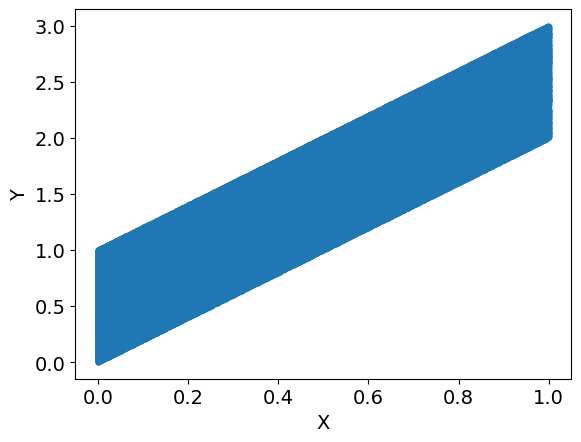

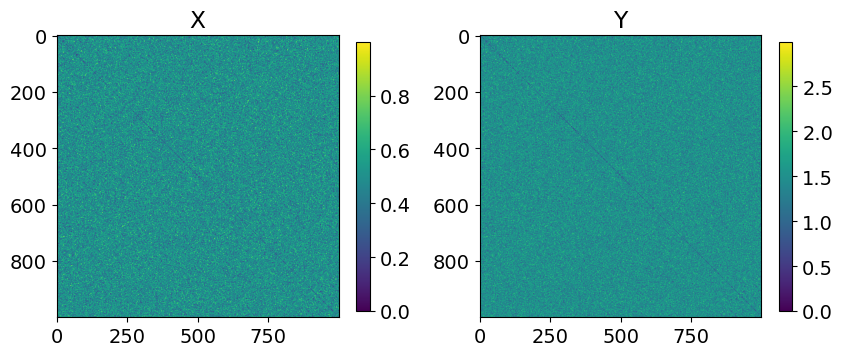

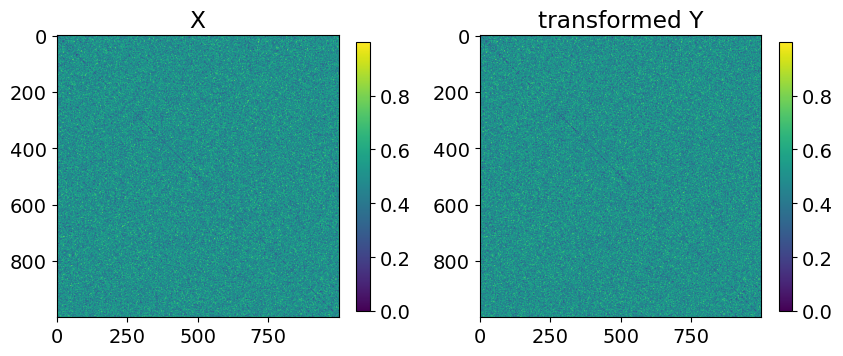

In [25]:
# RSA correlation
corr, _ = pearsonr(x_sim, y_sim)
print(f'pearson r = {corr}')

sc_plot(x_sim, y_sim, ['X', 'Y'])
im_plot(X, Y, ['X', 'Y'])

# histogram alignment
Y_t = histogram_matching(X, Y) ### ここのXとYが逆なような気がしますが・・・ (2023.5.15 佐々木)
im_plot(X, Y_t, ['X', 'transformed Y'])

It.  |Err         
-------------------
    0|1.475667e-04|
   10|5.825772e-08|
   20|6.459306e-10|


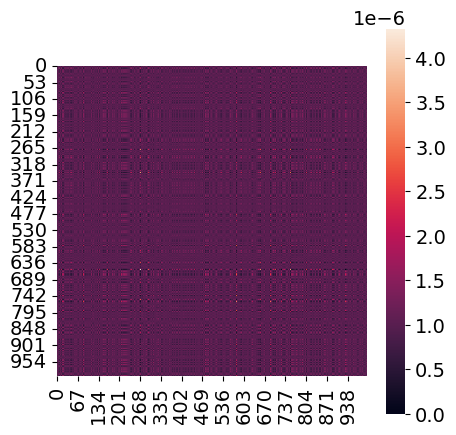

With histogram matching: GWD = 1.5001259764027646


In [26]:
# Normal GW alignment (without histogram matching)
epsilon = 0.0045
gw, log = gw_alignment(X, Y, epsilon=epsilon)
gwd = log['gw_dist']
print(f'With histogram matching: GWD = {gwd}')

It.  |Err         
-------------------
    0|5.289032e-04|
   10|7.818293e-19|


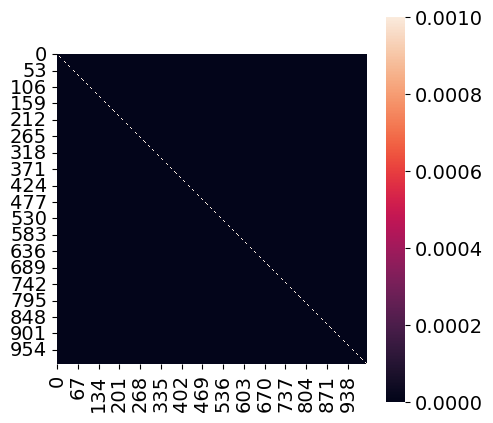

With histogram matching: GWD = 0.016646422050710794


In [27]:
# GW alignment after histogram matching
epsilon = 0.0005
gw_t, log_t = gw_alignment(X, Y_t, epsilon=epsilon)
gwd_t = log_t['gw_dist']
print(f'With histogram matching: GWD = {gwd_t}')  # %%

### 2023.5.15 佐々木
上記の `sort_for_scaling` だと、実データの場合に動かない場合がある。、

原因は。
1. どちらのmatrixも完全な対称行列ではないということ、
2. 対角成分に0以外のもの (どちらも1e-17のズレでもエラーとなる) 

があるという判定になっていることが原因なようです。

対策として、以下のようにすると、元の場合と同じ結果が得られるようになった。

In [28]:
def revised_sort_for_scaling(X):
    # x = squareform(X)
    x = X.flatten()
    x_sorted = np.sort(x)
    x_inverse_idx = np.argsort(x).argsort()
    return x, x_sorted, x_inverse_idx

def revised_histogram_matching(X, Y):
    # X, Y: dissimilarity matrices
    x, x_sorted, x_inverse_idx = revised_sort_for_scaling(X)
    y, y_sorted, y_inverse_idx = revised_sort_for_scaling(Y)

    y_t = x_sorted[y_inverse_idx]
    Y_t = y_t.reshape(Y.shape)  # transformed matrix
    return Y_t


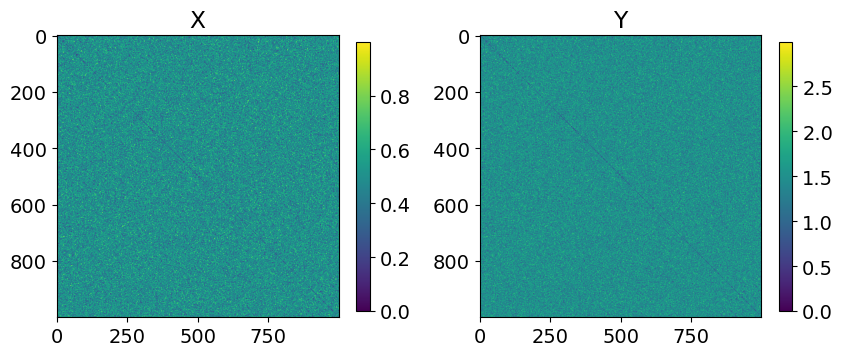

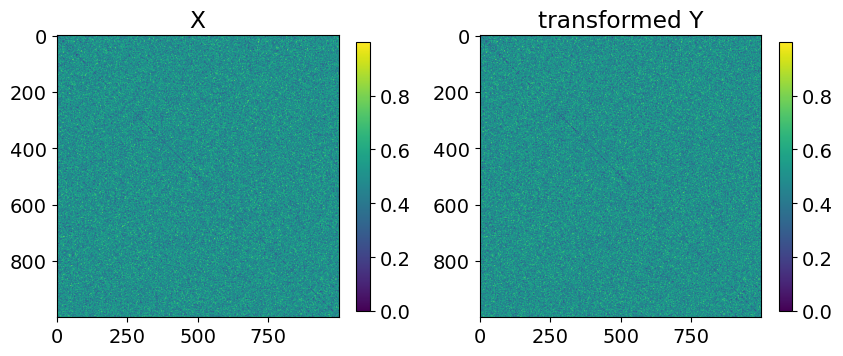

In [29]:
im_plot(X, Y, ['X', 'Y'])

# histogram alignment
Y_t = revised_histogram_matching(X, Y)
im_plot(X, Y_t, ['X', 'transformed Y'])

It.  |Err         
-------------------
    0|1.475667e-04|
   10|5.825772e-08|
   20|6.459306e-10|


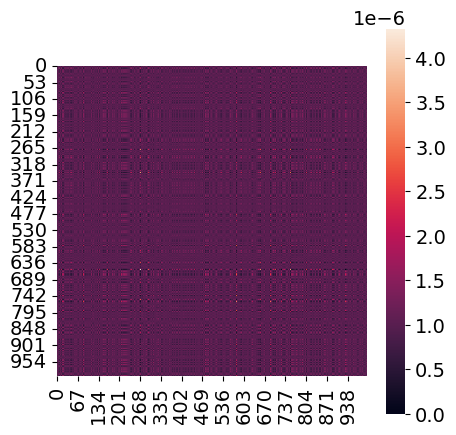

With histogram matching: GWD = 1.5001259764027646


In [30]:
# Normal GW alignment (without histogram matching)
epsilon = 0.0045
gw, log = gw_alignment(X, Y, epsilon=epsilon)
gwd = log['gw_dist']
print(f'With histogram matching: GWD = {gwd}')

It.  |Err         
-------------------
    0|5.289032e-04|
   10|7.818293e-19|


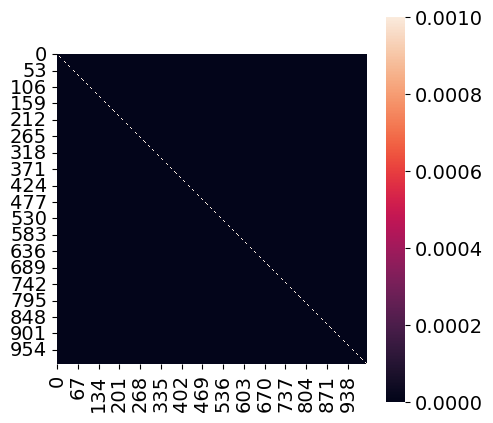

With histogram matching: GWD = 0.016646422050710794


In [31]:
# GW alignment after histogram matching
epsilon = 0.0005
gw_t, log_t = gw_alignment(X, Y_t, epsilon=epsilon)
gwd_t = log_t['gw_dist']
print(f'With histogram matching: GWD = {gwd_t}')  # %%